In [1]:
# to compress use find . -name "*.txt" -exec sh -c 'f="{}"; tar -czvf "${f%.txt}.tar.gz" "$f"' \;
# to uncompress tar -xzvf *.tar.gz

from pathlib import Path 
import pandas as pd
import tqdm
import socket
import struct
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns 

In [2]:

def make_windowed_features(df):
    # Function to convert IP string to integer
    def ip_to_int(ip):
        return struct.unpack("!I", socket.inet_aton(ip))[0]

    # Function to check if IPs are in subnet
    def is_ip_in_subnet(ip_array, subnet, mask_bits):
        subnet_int = ip_to_int(subnet)
        mask = (0xFFFFFFFF << (32 - mask_bits)) & 0xFFFFFFFF
        ip_ints = np.vectorize(ip_to_int)(ip_array)
        return (ip_ints & mask) == (subnet_int & mask)

    subnet = '192.168.0.0' # subnet of my lan 
    mask_bits = 24

    # Initialize new columns
    df['client'] = ''
    df['server'] = ''
    df['updown'] = 0  # -1 for download, +1 for upload

    # Perform vectorized subnet checks
    df.loc[:, 'src_in_subnet'] = is_ip_in_subnet(df['src_ip'].values, subnet, mask_bits)
    df.loc[:, 'dst_in_subnet'] = is_ip_in_subnet(df['dst_ip'].values, subnet, mask_bits)

    # Filter out rows where both src_ip and dst_ip are in the subnet (ignore internal traffic)
    internal_traffic_mask = df['src_in_subnet'] & df['dst_in_subnet']
    df = df[~internal_traffic_mask]

    # Assign 'client' and 'server' based on whether src_ip or dst_ip is in the subnet
    df.loc[:, 'client'] = np.where(df['src_in_subnet'], df['src_ip'], df['dst_ip'])
    df.loc[:, 'server'] = np.where(df['src_in_subnet'], df['dst_ip'], df['src_ip'])

    # Assign 'updown' based on whether src_ip or dst_ip is in the subnet
    df.loc[:, 'updown'] = np.where(df['src_in_subnet'], 1, -1)

    # turn string classes on numerical values
    # df.loc[:, 'ip_flag'] = pd.factorize(df.ip_flags)[0]
    df.loc[:, 'tcp_flag'] = pd.factorize(df.tcp_flags)[0] 

    # Drop the temporary columns
    df = df.drop(columns=['src_in_subnet', 'dst_in_subnet', 'src_ip', 'dst_ip', 'ip_flags', 'tcp_flags'])

    # 'time' column is in seconds (Unix timestamp)
    df['dttime'] = pd.to_datetime(df['time'], unit='s')
    # Set time as index for easier resampling
    df.set_index('dttime', inplace=True)
    # Define window size (10 seconds)
    window_size_seconds = 10
    window_size = f'{window_size_seconds}s'    
    # Now group by the window (resample) and calculate features
    grouped = df.resample(window_size)

    def entropy(df, colname):        
        prob_dist = df[colname].value_counts(normalize=True)# Step 1: Calculate probabilities        
        entropy = -np.sum(prob_dist * np.log2(prob_dist))  # Step 2: Calculate entropy
        return entropy

    # Function to calculate features for each client in each window
    def calculate_window_features(group):
        # Upload/Download packets 
        up_mask = group['updown'] > 0
        up_packets = group.loc[up_mask]
        dw_packets = group.loc[~up_mask]        
        up_pkt_avg = up_packets['packet_size'].mean()
        dw_pkt_avg = dw_packets['packet_size'].mean()
        up_pkt_var = up_packets['packet_size'].var()
        dw_pkt_var = dw_packets['packet_size'].var()
        up_pkt_sum = up_packets['packet_size'].sum()
        dw_pkt_sum = dw_packets['packet_size'].sum()      
        net_updown = up_pkt_sum - dw_pkt_sum  
        div_updown = up_packets['packet_size'].sum() / (dw_pkt_sum if dw_pkt_sum else 1)
        div_updown_var = up_pkt_var / (dw_pkt_var if dw_pkt_var else 1)

        pkt_entropy = entropy(group, 'packet_size')
        up_pkt_entropy = entropy(up_packets, 'packet_size')
        dw_pkt_entropy = entropy(dw_packets, 'packet_size')
        pkt_ack_entropy = entropy(group, 'tcp_ack')
        pkt_ttl_entropy = entropy(group, 'ttl')
        
        dw_ttl_unique = dw_packets['ttl'].nunique()
        dw_ttl_avg = dw_packets['ttl'].mean()
        tcp_ack_var = group['tcp_ack'].var()
        tcp_nports = group['tcp_sport'].nunique() + group['tcp_dport'].nunique() 
        udp_nports = group['udp_sport'].nunique() + group['udp_dport'].nunique() 
        # ip_flag = group['ip_flag'].nunique() - useless 2 values
        tcp_seq = group['tcp_seq'].nunique()
        tcp_ack = group['tcp_ack'].nunique()
        tcp_flag = group['tcp_flag'].nunique()


        # Packet delay average and variance
        group['time_diff'] = group.time.diff()  # Time difference between packets
        packet_delay_average =  group['time_diff'].mean()
        jitter =  group['time_diff'].var() # packet_delay_variance is jitter
        packet_delay_entropy = entropy(group, 'time_diff')

        # Connection multiplexing (unique destination IPs for each client)
        num_unique_ips = group['server'].nunique()

        return pd.Series({
            'pkt_entropy' : pkt_entropy,
            'up_pkt_entropy' : up_pkt_entropy,
            'dw_pkt_entropy' : dw_pkt_entropy,
            'up_speed': up_packets['packet_size'].sum()/window_size_seconds,
            'dw_speed': dw_packets['packet_size'].sum()/window_size_seconds,
            'net_updown' : net_updown,
            'div_updown' : div_updown,
            'div_updown_var' : div_updown_var,
            'up_pkt_var' : up_packets['packet_size'].var(),
            'dw_pkt_var' : dw_packets['packet_size'].var(),
            'up_pkt_avg' : up_pkt_avg,
            'dw_pkt_avg' : dw_pkt_avg,
            'dw_ttl_unique' : dw_ttl_unique,
            'dw_ttl_avg' : dw_ttl_avg,
            'tcp_ack_var' : tcp_ack_var,
            'updw_pkt' : dw_pkt_avg-up_pkt_avg,
            'dl_pkt_avg': packet_delay_average,
            'dl_pkt_entropy' : packet_delay_entropy,
            'jitter': jitter,
            'num_unique_ips': num_unique_ips,
            'tcp_nports' : tcp_nports,
            'udp_nports': udp_nports,
            'tcp_seq' : tcp_seq,
            'tcp_ack' : tcp_ack,
            'tcp_flags' : tcp_flag,
            'ttl_entropy' : pkt_ttl_entropy,
            'ack_entropy' : pkt_ack_entropy,
        })

    # groups of features on windows of 10 seconds
    gfeatures = grouped.apply(calculate_window_features).dropna()
    return gfeatures, df


In [3]:

# Define the column names corresponding to the fields in your output
columns = [
    'src_ip', 'dst_ip', 'packet_size', 'tcp_sport', 'tcp_dport', 'udp_sport', 
    'udp_dport', 'time', 'identification', 'ttl', 'ip_flags', 'tcp_seq', 
    'tcp_ack', 'tcp_flags'
]

data_path = Path.home() / 'Projects/netpkt_vidcls/python/data/'

df = pd.DataFrame()
for path in data_path.glob("working*.txt"):
    print(path)
    df_ = pd.read_csv(str(path.absolute()), sep=r'\s+', header=None, names=columns)
    dfeatures, df_ = make_windowed_features(df_)
    dfeatures['y'] = 0 # class 0 not video streaminig packets normal traffic
    df = pd.concat([df, dfeatures], ignore_index=True)

for path in list(data_path.glob("youtube*.txt"))+list(data_path.glob("insta*.txt")):
    print(path)
    df_ = pd.read_csv(str(path.absolute()), sep=r'\s+', header=None, names=columns)
    dfeatures, df_ = make_windowed_features(df_)
    dfeatures['y'] = 1 # class 1 video streaming packets
    df = pd.concat([df, dfeatures], ignore_index=True)

/home/andre/Projects/netpkt_vidcls/python/data/working_packets_01.txt


/tmp/ipykernel_443126/228908889.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'tcp_flag'] = pd.factorize(df.tcp_flags)[0]


/home/andre/Projects/netpkt_vidcls/python/data/working_packets_02.txt
/home/andre/Projects/netpkt_vidcls/python/data/working_packets_03.txt
/home/andre/Projects/netpkt_vidcls/python/data/youtube_packets_03.txt
/home/andre/Projects/netpkt_vidcls/python/data/youtube_packets_02.txt
/home/andre/Projects/netpkt_vidcls/python/data/youtube_packets_01.txt
/home/andre/Projects/netpkt_vidcls/python/data/insta_packets_01.txt
/home/andre/Projects/netpkt_vidcls/python/data/insta_packets_02.txt


In [4]:
df

,pkt_entropy,up_pkt_entropy,dw_pkt_entropy,up_speed,dw_speed,net_updown,div_updown,div_updown_var,up_pkt_var,dw_pkt_var,...,jitter,num_unique_ips,tcp_nports,udp_nports,tcp_seq,tcp_ack,tcp_flags,ttl_entropy,ack_entropy,y
0,1.061278,0.811278,0.811278,25.1,24.8,3.0,1.012097,1.155625,4.622500e+02,4.000000e+02,...,0.154532,3.0,8.0,2.0,7.0,7.0,2.0,1.750000,2.750000,0
1,4.358154,4.009961,3.724100,1850.2,2432.7,-5825.0,0.760554,0.970332,2.732001e+05,2.815534e+05,...,0.236659,5.0,14.0,10.0,16.0,15.0,3.0,1.775414,1.591154,0
2,3.290326,3.072503,2.348076,5702.0,2340.4,33616.0,2.436336,0.735347,1.274288e+06,1.732906e+06,...,0.015348,1.0,12.0,2.0,75.0,56.0,6.0,1.326768,5.471320,0
3,3.285510,3.206585,2.268999,4704.3,771.4,39329.0,6.098393,2.888841,1.598322e+06,5.532744e+05,...,0.120513,6.0,15.0,6.0,49.0,43.0,8.0,1.477488,5.038614,0
4,4.889996,2.938537,5.178902,6904.2,290999.3,-2840951.0,0.023726,0.003256,1.450910e+05,4.455968e+07,...,0.011582,4.0,20.0,14.0,380.0,245.0,6.0,1.597554,4.719222,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,0.912438,1.943002,0.219533,7077.8,589591.0,-5825132.0,0.012005,8.414131,1.941330e+05,2.307225e+04,...,0.000948,10.0,18.0,12.0,35.0,34.0,3.0,0.613086,0.128366,1
895,1.685583,3.252448,0.746165,4367.4,133919.2,-1295518.0,0.032612,4.077505,3.694257e+05,9.060092e+04,...,0.004310,10.0,16.0,12.0,33.0,33.0,3.0,0.996038,0.421786,1
896,1.411189,2.600355,0.593743,620.3,57564.4,-569441.0,0.010776,0.098707,7.610826e+03,7.710532e+04,...,0.041343,8.0,18.0,8.0,22.0,22.0,4.0,0.795918,0.470687,1
897,3.915058,3.702683,3.047983,2043.8,845.0,11988.0,2.418698,7.626496,8.418639e+05,1.103867e+05,...,0.066868,8.0,16.0,8.0,31.0,31.0,3.0,1.798964,3.395171,1


In [5]:
df_

,packet_size,tcp_sport,tcp_dport,udp_sport,udp_dport,time,identification,ttl,tcp_seq,tcp_ack,client,server,updown,tcp_flag
dttime,,,,,,,,,,,,,,
2024-09-13 00:09:46.534718037,283,60012,443,-1,-1,1.726186e+09,20541,64,2130862059,1510500413,192.168.0.100,200.198.193.226,1,0
2024-09-13 00:09:46.563438892,52,443,60012,-1,-1,1.726186e+09,4965,50,1510500413,2130862290,192.168.0.100,200.198.193.226,-1,1
2024-09-13 00:09:47.205106020,84,39424,443,-1,-1,1.726186e+09,61889,64,3020513181,2678810466,192.168.0.100,57.144.136.192,1,0
2024-09-13 00:09:47.235002995,52,443,39424,-1,-1,1.726186e+09,46040,52,2678810466,3020513213,192.168.0.100,57.144.136.192,-1,1
2024-09-13 00:09:47.488550901,80,443,39424,-1,-1,1.726186e+09,46041,52,2678810466,3020513213,192.168.0.100,57.144.136.192,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-13 00:19:05.726516962,59,-1,-1,34661,443,1.726187e+09,54722,64,-1,-1,192.168.0.100,142.250.219.142,1,2
2024-09-13 00:19:05.726783991,53,-1,-1,443,34661,1.726187e+09,0,59,-1,-1,192.168.0.100,142.250.219.142,-1,2
2024-09-13 00:19:05.727348089,57,-1,-1,443,34661,1.726187e+09,0,59,-1,-1,192.168.0.100,142.250.219.142,-1,2


In [6]:
df

,pkt_entropy,up_pkt_entropy,dw_pkt_entropy,up_speed,dw_speed,net_updown,div_updown,div_updown_var,up_pkt_var,dw_pkt_var,...,jitter,num_unique_ips,tcp_nports,udp_nports,tcp_seq,tcp_ack,tcp_flags,ttl_entropy,ack_entropy,y
0,1.061278,0.811278,0.811278,25.1,24.8,3.0,1.012097,1.155625,4.622500e+02,4.000000e+02,...,0.154532,3.0,8.0,2.0,7.0,7.0,2.0,1.750000,2.750000,0
1,4.358154,4.009961,3.724100,1850.2,2432.7,-5825.0,0.760554,0.970332,2.732001e+05,2.815534e+05,...,0.236659,5.0,14.0,10.0,16.0,15.0,3.0,1.775414,1.591154,0
2,3.290326,3.072503,2.348076,5702.0,2340.4,33616.0,2.436336,0.735347,1.274288e+06,1.732906e+06,...,0.015348,1.0,12.0,2.0,75.0,56.0,6.0,1.326768,5.471320,0
3,3.285510,3.206585,2.268999,4704.3,771.4,39329.0,6.098393,2.888841,1.598322e+06,5.532744e+05,...,0.120513,6.0,15.0,6.0,49.0,43.0,8.0,1.477488,5.038614,0
4,4.889996,2.938537,5.178902,6904.2,290999.3,-2840951.0,0.023726,0.003256,1.450910e+05,4.455968e+07,...,0.011582,4.0,20.0,14.0,380.0,245.0,6.0,1.597554,4.719222,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,0.912438,1.943002,0.219533,7077.8,589591.0,-5825132.0,0.012005,8.414131,1.941330e+05,2.307225e+04,...,0.000948,10.0,18.0,12.0,35.0,34.0,3.0,0.613086,0.128366,1
895,1.685583,3.252448,0.746165,4367.4,133919.2,-1295518.0,0.032612,4.077505,3.694257e+05,9.060092e+04,...,0.004310,10.0,16.0,12.0,33.0,33.0,3.0,0.996038,0.421786,1
896,1.411189,2.600355,0.593743,620.3,57564.4,-569441.0,0.010776,0.098707,7.610826e+03,7.710532e+04,...,0.041343,8.0,18.0,8.0,22.0,22.0,4.0,0.795918,0.470687,1
897,3.915058,3.702683,3.047983,2043.8,845.0,11988.0,2.418698,7.626496,8.418639e+05,1.103867e+05,...,0.066868,8.0,16.0,8.0,31.0,31.0,3.0,1.798964,3.395171,1


In [17]:
# when uploading source port of client is going to be "anything" but destination 80 or 443
# when downloading destination port (or client port) will be 80 or 443 but source (from server) can be "anything"
# should remove here useless - only one port for udp and one port for tcp is useful other is fixed hence meaningless... ?
# 80 or 443 ... hum... altough 80 != 443 hence might contain some information


In [18]:
# plt.figure(figsize=(10, 6))
# sns.histplot(data=df, x='tcp_seq', hue='y', element='step', stat='density', 
#     common_norm=False, cumulative=False)
# # plt.title('TTL Distribution for Video Streaming vs Web Surfing')
# # plt.xlabel('Time to Live (TTL)')
# # plt.ylabel('Density')
# plt.show()

In [19]:
# plt.figure(figsize=(20,20))
# sns.pairplot(df, hue='y', vars=df.columns.values[:-6].tolist(), plot_kws={'alpha': 0.5})
# plt.show()

<Axes: >

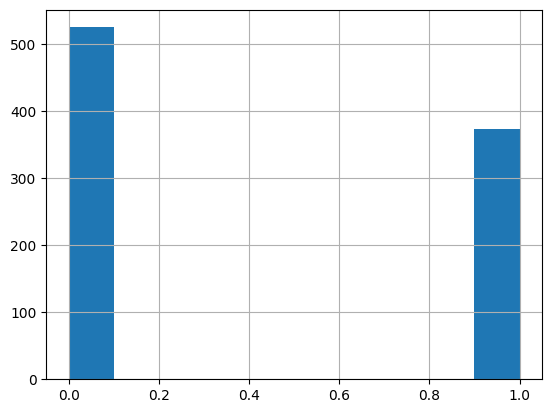

In [7]:
df.y.hist()

In [ ]:
# 7th more importante features -> gives ~93% accuracy in average
selected_features = ['ack_entropy', 'ttl_entropy', 'tcp_ack_var', 'pkt_entropy', 
                     'udp_nports', 'dw_ttl_avg', 'dw_ttl_unique']

In [26]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

scores = []
for i in range(300):
    X = df.sample(frac=1) # shuffle samples
    size = len(X)
    ratio = 0.8 # 0.8 for training
    X = X[X[selected_features].columns.to_list() + ['y']] # reducing features
    X_train, y_train = X.drop(columns=['y']).iloc[:int(ratio*size)], X['y'].iloc[:int(ratio*size)]
    X_score, y_score = X.drop(columns=['y']).iloc[int(ratio*size):], X['y'].iloc[int(ratio*size):]

    # Train the model    
    #rf = RandomForestClassifier(n_estimators=100, random_state=42)l
    rf = ExtraTreesClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    # index = 1500
    # sample = pd.DataFrame(X.iloc[index]).transpose()
    # print(rf.predict_proba(sample), y.iloc[index])
    score = 100*rf.score(X_score, y_score)
    print(f"Mean accuracy {i:3d} is {score: .2f} %", end='\r')
    scores.append(score)
print(f"Average of {i} random splits - mean accuracy is {np.mean(np.array(scores)): .2f} %")

Average of 299 random splits - mean accuracy is  93.81 %


In [ ]:
np.percentile(np.array(scores), [5, 10, 50, 90]) # 95% time its above 91% acuracy 

array([91.08333333, 91.66666667, 93.88888889, 96.11111111])